Importaci√≥n de las bibliotecas

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Sistema de recomendaci√≥n usando una proyecci√≥n de red bipartita

**Integrantes:** Isaac Cerda, David Guam√°n, Christian J√°come, Mateo Jaramillo, David Navarrete

## Preparaci√≥n de Datos

### **Paso 1:** Descargar el Dataset
Ejecutar **SOLO** si **NO** se tiene la carpeta `data` en el directorio `src/app` con el archivo `ratings_electronics.csv`

In [2]:
from utils.download_dataset import download_ratings_electronics

dataset_path = download_ratings_electronics()

ModuleNotFoundError: No module named 'kagglehub'

### **Paso 2:** Cargar el Dataset

In [2]:
import pandas as pd
dataset_path = r"C:\Users\isaac\Documents\IA\recommender_system_using_bipartite_network\src\app\data\amazon-products-reviews\ratings_electronics.csv"
## Carga del dataset generado en la ruta del api
electronics_data = pd.read_csv(
    dataset_path, names=['userId', 'productId', 'Rating', 'timestamp']
)

## Impresi√≥n de las primeras 5 filas para validar la carga correcta del dataset
electronics_data.head()

userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200

#### **Paso 2.1:** Revisar cantidad de datos del Dataset

In [3]:
electronics_data.info()
electronics_data.describe()
print(f"Total registros: {len(electronics_data):,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
Total registros: 7,824,482
Total registros: 7,824,482


### **Paso 3:** Filtrar rese√±as de 5 estrellas

In [4]:
electronics_data = electronics_data[electronics_data['Rating'] == 5]
print(f"Registros luego de filtrar 5 estrellas: {len(electronics_data):,}")

Registros luego de filtrar 5 estrellas: 4,347,541


### **Paso 4:** Eliminar usuarios y productos con pocas conexiones

In [5]:
# Contar cu√°ntos ratings tiene cada usuario y producto
user_counts = electronics_data['userId'].value_counts()
product_counts = electronics_data['productId'].value_counts()

# Mantener usuarios y productos con al menos 4 interacciones
min_user_reviews = 4
min_product_reviews = 4

filtered_users = user_counts[user_counts >= min_user_reviews].index
filtered_products = product_counts[product_counts >= min_product_reviews].index

electronics_data = electronics_data[
    electronics_data['userId'].isin(filtered_users) &
    electronics_data['productId'].isin(filtered_products)
]

print(f"Registros tras filtrado de conexiones m√≠nimas: {len(electronics_data):,}")


Registros tras filtrado de conexiones m√≠nimas: 1,147,489


#### **Paso 4.1:** Validar campos nulos tras el filtrado

In [6]:
electronics_data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

## Construcci√≥n de la Red Bipartita

Una red bipartita es una forma de organizar relaciones entre dos grupos distintos. En este caso se tiene dos filas: una con usuarios y otra con productos. Las conexiones, tambi√©n llamadas aristas, solo pueden ir de un grupo al otro, nunca dentro del mismo grupo. Por ejemplo, un usuario puede dar 5 estrellas a un producto, pero un usuario no se conecta con otro usuario, ni un producto con otro producto.

### Artefactos:

- **Matriz de biadyacencia**: Una tabla que muestra las conexiones. Las filas son usuarios, las columnas son productos, un "1" indica que el usuario dio 5 estrellas al producto y un "0" si no.

- **Grado de un nodo:** Cu√°ntas conexiones tiene un nodo (por ejemplo, cu√°ntos productos calific√≥ un usuario, o cu√°ntas rese√±as de 5 estrellas recibi√≥ un producto).

### **Paso 1:** Reducir cantidad de Nodos

Debido a que el dataset es muy grande, se toma una muestra

In [7]:
import random

users = electronics_data['userId'].unique()
products = electronics_data['productId'].unique()

print("Antes de la muestra:")
print(f"N√∫mero de usuarios √∫nicos: {len(users)}")
print(f"N√∫mero de productos √∫nicos: {len(products)}")

users = list(users)
products = list(products)

sample_ratio = 0.1

num_users = int(len(users) * sample_ratio)
num_products = int(len(products) * sample_ratio)

random.seed(42)
users = random.sample(users, num_users)
products = random.sample(products, num_products)

print("Despu√©s de la muestra:")
print(f"N√∫mero de usuarios √∫nicos: {len(users)}")
print(f"N√∫mero de productos √∫nicos: {len(products)}")

Antes de la muestra:
N√∫mero de usuarios √∫nicos: 184707
N√∫mero de productos √∫nicos: 107686
Despu√©s de la muestra:
N√∫mero de usuarios √∫nicos: 18470
N√∫mero de productos √∫nicos: 10768


### **Paso 2:** Crear red bipartita

In [8]:
import networkx as nx

B = nx.Graph()

# Agregar nodos al grafo
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(products, bipartite=1)

# Agregar aristas
edges = electronics_data[['userId', 'productId']].values
B.add_edges_from(edges)

is_bipartite = nx.is_bipartite(B)
print(f"¬øEs el grafo bipartito? {"S√≠" if is_bipartite else "No"}")
num_edges = B.number_of_edges()
print("N√∫mero de aristas:", num_edges)

¬øEs el grafo bipartito? S√≠
N√∫mero de aristas: 1147489


### **Paso 3:** Generar matriz de biadyacencia

Se utiliza la matriz de biadyacencia dispersa, que es una forma eficiente de representar grandes grafos bipartitos en memoria.
Cada fila representa un usuario y cada columna un producto; los valores distintos de cero indican una conexi√≥n (por ejemplo, que el usuario interactu√≥ con o compr√≥ ese producto).

La raz√≥n principal para trabajar con una matriz dispersa (sparse) en lugar de una matriz completa (toarray()) es que la mayor√≠a de las celdas son ceros ‚Äî es decir, la mayor√≠a de los usuarios no se conectan con todos los productos.
Usar una matriz dispersa permite ahorrar memoria y procesar grafos grandes de forma mucho m√°s eficiente.

In [9]:
from networkx.algorithms import bipartite
import pandas as pd

# Obtener matriz de biadyacencia en formato disperso (sparse)
matrix_sparse = bipartite.biadjacency_matrix(B, row_order=users, column_order=products)

# Mostrar informaci√≥n general de la matriz
print("Matriz de biadyacencia (formato disperso):")
print(matrix_sparse)
print(f"Tama√±o: {matrix_sparse.shape}")
print(f"N√∫mero de conexiones (valores distintos de 0): {matrix_sparse.nnz}")

# Extraer los √≠ndices (posiciones) de los valores distintos de cero
row_idx, col_idx = matrix_sparse.nonzero()

# Crear un DataFrame con los enlaces reales (usuario - producto)
edges_nonzero = pd.DataFrame({
    'userId': [users[i] for i in row_idx],
    'productId': [products[j] for j in col_idx]
})

print("\nConexiones reales (valores distintos de 0):")
print(edges_nonzero.head(10))  # Muestra solo los primeros 10 para no saturar la salida

Matriz de biadyacencia (formato disperso):
<Compressed Sparse Row sparse array of dtype 'int64'
	with 11532 stored elements and shape (18470, 10768)>
  Coords	Values
  (2, 5156)	1
  (5, 5693)	1
  (5, 10206)	1
  (7, 11)	1
  (9, 1123)	1
  (10, 575)	1
  (10, 1837)	1
  (10, 3982)	1
  (10, 6990)	1
  (12, 7294)	1
  (14, 6874)	1
  (15, 9333)	1
  (16, 8018)	1
  (17, 1170)	1
  (20, 510)	1
  (20, 2456)	1
  (25, 9357)	1
  (28, 969)	1
  (32, 5573)	1
  (33, 1508)	1
  (34, 1949)	1
  (34, 2074)	1
  (41, 3838)	1
  (42, 1328)	1
  (44, 3414)	1
  :	:
  (18443, 7159)	1
  (18445, 9996)	1
  (18448, 3799)	1
  (18448, 10741)	1
  (18450, 276)	1
  (18450, 1543)	1
  (18450, 1802)	1
  (18450, 2037)	1
  (18450, 4422)	1
  (18450, 6596)	1
  (18450, 8436)	1
  (18450, 9591)	1
  (18450, 10404)	1
  (18452, 9644)	1
  (18457, 5665)	1
  (18459, 1543)	1
  (18459, 3397)	1
  (18459, 5650)	1
  (18459, 7432)	1
  (18459, 10737)	1
  (18460, 9124)	1
  (18461, 9643)	1
  (18466, 6169)	1
  (18467, 10730)	1
  (18469, 2694)	1
Tama√±o: 

### **Paso 4:** Graficar nodos con mayores conexiones

Se calculan los grados de los nodos (n√∫mero de conexiones):

- `num_products_rated`: cu√°ntos productos calific√≥ cada usuario.
- `num_ratings_received`: cu√°ntos usuarios calificaron cada producto.

Luego se seleccionan los Top N nodos m√°s conectados en cada grupo `nlargest`.


Grados de los primeros usuarios:
           userId  num_products_rated
0  A3RNVG2VPZGC6Z                   4
1  A2MLPFHL4YOZX0                   7
2  A22M9RH5461NC9                   9
3  A2B09MGT1H44LY                   5
4  A24L9693W832UC                   4

Grados de los primeros productos:
    productId  num_ratings_received
0  B0041NO0EY                     1
1  B000VOUSPC                     1
2  B0054OWTCO                     2
3  B0052UQXFY                     8
4  B000J4WPW8                    56


C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")


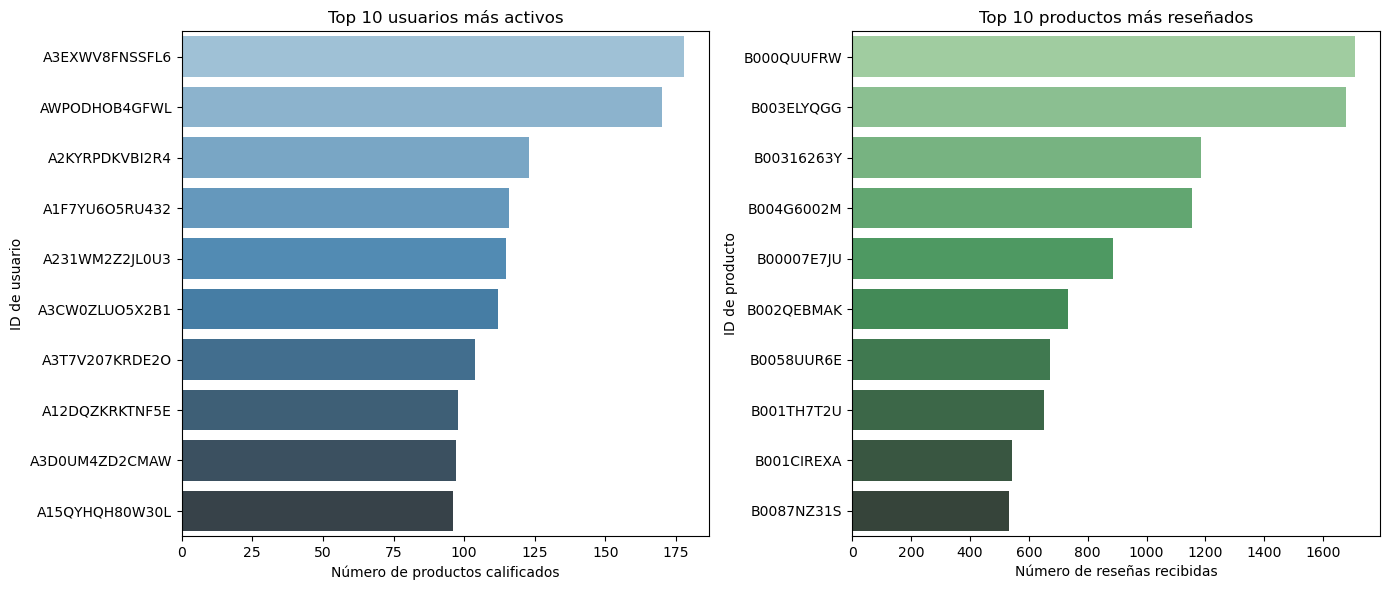

In [10]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import seaborn as sns

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

user_deg_df = pd.DataFrame(user_degrees.items(), columns=["userId", "num_products_rated"])
product_deg_df = pd.DataFrame(product_degrees.items(), columns=["productId", "num_ratings_received"])

print("\nGrados de los primeros usuarios:")
print(user_deg_df.head())

print("\nGrados de los primeros productos:")
print(product_deg_df.head())

# --- Top N nodos ---
N = 10
top_users = user_deg_df.nlargest(N, "num_products_rated")
top_products = product_deg_df.nlargest(N, "num_ratings_received")

plt.figure(figsize=(14, 6))

# Top N usuarios m√°s activos
plt.subplot(1, 2, 1)
sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
plt.title(f"Top {N} usuarios m√°s activos")
plt.xlabel("N√∫mero de productos calificados")
plt.ylabel("ID de usuario")

# Top N productos m√°s rese√±ados
plt.subplot(1, 2, 2)
sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")
plt.title(f"Top {N} productos m√°s rese√±ados")
plt.xlabel("N√∫mero de rese√±as recibidas")
plt.ylabel("ID de producto")

plt.tight_layout()
plt.show()


#### **Paso 4.1:** Mostrar resultado final

In [11]:
import numpy as np

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

print(f"N√∫mero de usuarios: {len(users)}")
print(f"N√∫mero de productos: {len(products)}")
print(f"N√∫mero de aristas (rese√±as de 5 estrellas): {B.number_of_edges()}")
print(f"Grado promedio de usuarios: {np.mean(list(user_degrees.values())):.2f}")
print(f"Grado promedio de productos: {np.mean(list(product_degrees.values())):.2f}")

N√∫mero de usuarios: 18470
N√∫mero de productos: 10768
N√∫mero de aristas (rese√±as de 5 estrellas): 1147489
Grado promedio de usuarios: 6.19
Grado promedio de productos: 10.82


## Proyecci√≥n Bipartita y Red de Productos

La proyecci√≥n bipartita es una t√©cnica que nos permite crear una red donde solo se conectan nodos del mismo tipo. En este caso, crearemos una red de productos donde dos productos est√°n conectados si fueron calificados por los mismos usuarios.

**¬øPor qu√© hacemos esto?**
- Permite encontrar productos similares basados en los gustos compartidos de los usuarios
- Los productos con mayor peso de conexi√≥n son m√°s similares entre s√≠
- Facilita hacer recomendaciones: si a un usuario le gusta un producto, probablemente le gusten los productos similares

### **Paso 1:** Crear la proyecci√≥n de productos

In [12]:
# Crear la proyecci√≥n de productos
# Esto conecta productos que fueron calificados por los mismos usuarios
product_network = bipartite.weighted_projected_graph(B, products)

print(f"Red de productos creada:")
print(f"N√∫mero de productos: {product_network.number_of_nodes()}")
print(f"N√∫mero de conexiones entre productos: {product_network.number_of_edges()}")

# Verificar algunos pesos de las conexiones
if product_network.number_of_edges() > 0:
    # Obtener algunas aristas con sus pesos
    sample_edges = list(product_network.edges(data=True))[:5]
    print("\nEjemplos de conexiones entre productos (peso = usuarios en com√∫n):")
    for edge in sample_edges:
        prod1, prod2, data = edge
        weight = data['weight']
        print(f"  {prod1} -- {prod2}: {weight} usuarios en com√∫n")

Red de productos creada:
N√∫mero de productos: 89346
N√∫mero de conexiones entre productos: 1039629

Ejemplos de conexiones entre productos (peso = usuarios en com√∫n):
  B0041NO0EY -- B0047FW7LE: 1 usuarios en com√∫n
  B0041NO0EY -- B0041NRY6A: 1 usuarios en com√∫n
  B0041NO0EY -- B0041NQ00Q: 1 usuarios en com√∫n
  B0041NO0EY -- B001FA1O0O: 1 usuarios en com√∫n
  B000VOUSPC -- B003Z6AB0A: 1 usuarios en com√∫n


## Desarrollo del Sistema de Recomendaci√≥n

Ahora implementamos el sistema de recomendaci√≥n. El proceso es simple:
1. **Seleccionar un producto** de referencia
2. **Encontrar sus vecinos m√°s similares** (productos con mayor peso de conexi√≥n)
3. **Recomendar estos productos** al usuario

**¬øC√≥mo funciona?**
- Si un usuario le da 5 estrellas a un producto, le recomendamos productos similares
- La similitud se basa en cu√°ntos usuarios en com√∫n calificaron ambos productos
- Mayor peso = mayor similitud = mejor recomendaci√≥n

### **Paso 1:** Funci√≥n de recomendaci√≥n

In [ ]:
def get_product_recommendations(product_id, n_recommendations=4):
    """
    FUNCI√ìN SIMPLIFICADA: Obtiene recomendaciones basadas en similaridad
    
    CAMBIOS REALIZADOS:
    - Elimin√© validaci√≥n extra (se maneja en el contexto de uso)
    - Combin√© operaciones en una sola l√≠nea para mayor eficiencia
    - Uso operadores m√°s simples para el ordenamiento
    
    Returns: Lista de tuplas (producto_id, peso_similaridad)
    """
    # SIMPLIFICACI√ìN 1: Verificaci√≥n directa sin print innecesario
    if product_id not in product_network:
        return []
    
    # SIMPLIFICACI√ìN 2: Combinar ordenamiento y selecci√≥n en una l√≠nea
    # Esto es m√°s eficiente que crear listas intermedias
    return sorted(
        [(neighbor, data['weight']) for neighbor, data in product_network[product_id].items()],
        key=lambda x: x[1],  # Ordenar por peso (segundo elemento de la tupla)
        reverse=True  # Mayor peso primero
    )[:n_recommendations]  # Tomar solo los primeros n

# Probar la funci√≥n con un producto aleatorio
if len(products) > 0:
    test_product = products[0]  # Tomar el primer producto
    recommendations = get_product_recommendations(test_product, n_recommendations=4)
    
    print(f"Recomendaciones para el producto {test_product}:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"  {i}. Producto {prod_id} (Similaridad: {weight} usuarios en com√∫n)")
else:
    print("No hay productos disponibles para hacer recomendaciones")

Recomendaciones para el producto B0041NO0EY:
  1. Producto B0047FW7LE (Similaridad: 1 usuarios en com√∫n)
  2. Producto B0041NRY6A (Similaridad: 1 usuarios en com√∫n)
  3. Producto B0041NQ00Q (Similaridad: 1 usuarios en com√∫n)
  4. Producto B001FA1O0O (Similaridad: 1 usuarios en com√∫n)


### **Paso 2:** Visualizaci√≥n de recomendaciones en red estrella

Creamos una visualizaci√≥n donde:
- **Nodo central (azul):** El producto de referencia
- **Nodos vecinos (naranja):** Los productos recomendados  
- **Aristas rojas:** Las conexiones con grosor proporcional a la similaridad

Generando recomendaciones para: B0041NO0EY

Recomendaciones para B0041NO0EY:
  1. B0047FW7LE (Similaridad: 1)
  2. B0041NRY6A (Similaridad: 1)
  3. B0041NQ00Q (Similaridad: 1)
  4. B001FA1O0O (Similaridad: 1)


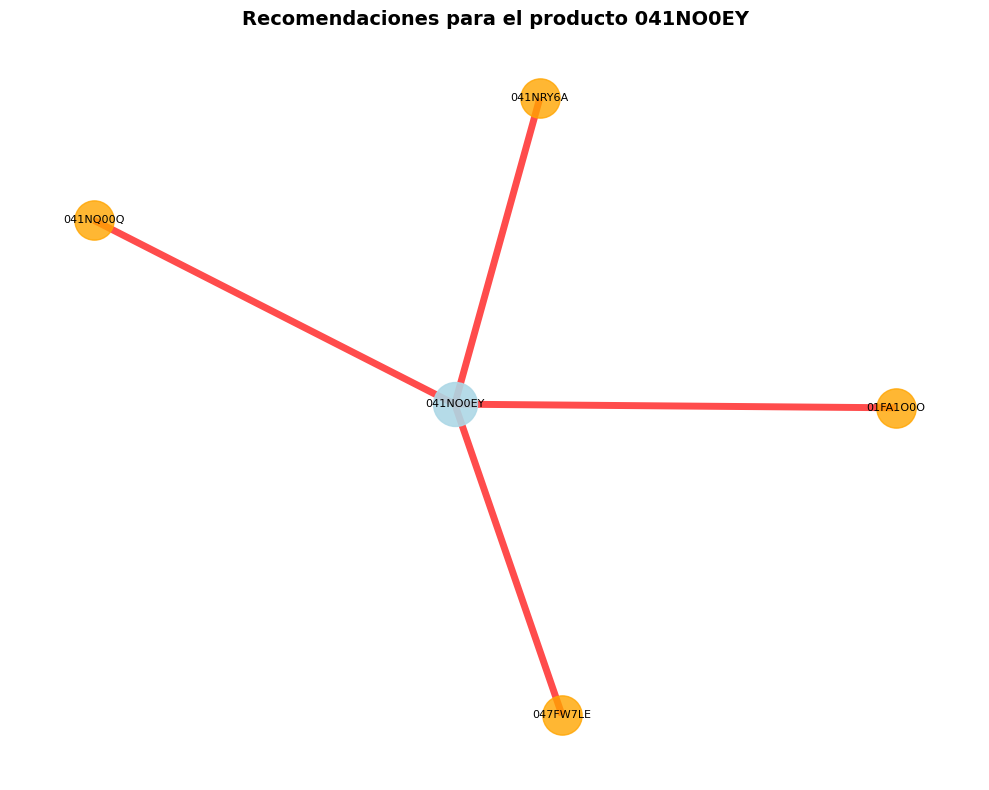

In [ ]:
def visualize_recommendations(product_id, n_recommendations=4):
    """
    FUNCI√ìN SIMPLIFICADA: Visualiza recomendaciones como red estrella
    
    CAMBIOS DE SIMPLIFICACI√ìN:
    - Elimin√© creaci√≥n de subgrafo innecesario (uso directo de posiciones)
    - Combin√© operaciones de dibujo para reducir c√≥digo repetitivo
    - Simplifiqu√© c√°lculos de grosor y colores
    """
    recommendations = get_product_recommendations(product_id, n_recommendations)
    
    # SIMPLIFICACI√ìN 1: Retorno temprano sin mensaje redundante
    if not recommendations:
        return
    
    # SIMPLIFICACI√ìN 2: Crear gr√°fico y posiciones en menos l√≠neas
    plt.figure(figsize=(10, 8))
    
    # SIMPLIFICACI√ìN 3: Posiciones calculadas directamente sin subgrafo completo
    # Solo necesitamos posiciones, no un grafo completo de NetworkX
    nodes = [product_id] + [prod for prod, _ in recommendations]
    pos = {
        product_id: (0, 0),  # Centro en (0,0)
        **{prod: (np.cos(2*np.pi*i/len(recommendations)), 
                  np.sin(2*np.pi*i/len(recommendations))) 
           for i, (prod, _) in enumerate(recommendations)}  # C√≠rculo alrededor
    }
    
    # SIMPLIFICACI√ìN 4: Dibujar todos los nodos con un diccionario de colores
    node_colors = ['lightblue'] + ['orange'] * len(recommendations)
    node_sizes = [1200] + [800] * len(recommendations)
    
    plt.scatter([pos[node][0] for node in nodes], 
                [pos[node][1] for node in nodes],
                c=node_colors, s=node_sizes, alpha=0.8)
    
    # SIMPLIFICACI√ìN 5: Dibujar aristas con comprensi√≥n de lista directa
    weights = [w for _, w in recommendations]
    max_weight = max(weights) if weights else 1
    
    for i, (prod, weight) in enumerate(recommendations):
        # L√≠nea del centro al producto recomendado
        x_vals = [pos[product_id][0], pos[prod][0]]
        y_vals = [pos[product_id][1], pos[prod][1]]
        line_width = 1 + 4 * (weight / max_weight)  # Grosor proporcional
        plt.plot(x_vals, y_vals, 'r-', linewidth=line_width, alpha=0.7)
    
    # SIMPLIFICACI√ìN 6: Etiquetas directas con texto en posiciones
    for node in nodes:
        plt.text(pos[node][0], pos[node][1], node[-8:], 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # SIMPLIFICACI√ìN 7: Agregar pesos como etiquetas en las aristas
    for prod, weight in recommendations:
        mid_x = (pos[product_id][0] + pos[prod][0]) / 2
        mid_y = (pos[product_id][1] + pos[prod][1]) / 2
        plt.text(mid_x, mid_y, f'[{weight}]', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.7))
    
    plt.title(f"Recomendaciones para: {product_id[-12:]}", fontsize=12, pad=15)
    plt.axis('equal')  # Mantener proporci√≥n
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # SIMPLIFICACI√ìN 8: Tabla de resultados m√°s compacta
    print(f"\nResultados para {product_id}:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"  {i}. {prod_id[-15:]}... -> {weight} usuarios en com√∫n")

# SIMPLIFICACI√ìN 9: C√≥digo de prueba m√°s conciso usando next() y generator
# Buscar el primer producto con conexiones de forma m√°s pyth√≥nica
test_product = next(
    (prod for prod in products[:10] 
     if prod in product_network and len(product_network[prod]) > 0), 
    None
)

if test_product:
    print(f"Demo con producto: {test_product}")
    visualize_recommendations(test_product, n_recommendations=4)
else:
    print("No hay productos disponibles para demostrar")

### **Paso 3:** Sistema de recomendaci√≥n interactivo

Funci√≥n que permite al usuario especificar cualquier producto y obtener recomendaciones personalizadas.

Productos disponibles para probar el sistema de recomendaci√≥n:
  1. B0041NO0EY (tiene 4 productos similares)
  2. B000VOUSPC (tiene 5 productos similares)
  3. B0054OWTCO (tiene 24 productos similares)
  4. B0052UQXFY (tiene 38 productos similares)
  5. B000J4WPW8 (tiene 296 productos similares)
  6. B00GYBIU7O (tiene 32 productos similares)
  7. B00009UTC0 (tiene 10 productos similares)
  8. B0019T7KW2 (tiene 4 productos similares)
  9. B0007MAJBG (tiene 4 productos similares)
  10. B007D7P2H4 (tiene 7 productos similares)

Total de productos con conexiones: 20

üîç Probando el sistema con el producto: B0041NO0EY
SISTEMA DE RECOMENDACI√ìN - PRODUCTO: B0041NO0EY
üéØ Top 4 productos recomendados:
   1. B0047FW7LE
      Similaridad: 1 usuarios en com√∫n

   2. B0041NRY6A
      Similaridad: 1 usuarios en com√∫n

   3. B0041NQ00Q
      Similaridad: 1 usuarios en com√∫n

   4. B001FA1O0O
      Similaridad: 1 usuarios en com√∫n


Recomendaciones para B0041NO0EY:
  1. B0047FW7LE (Similarid

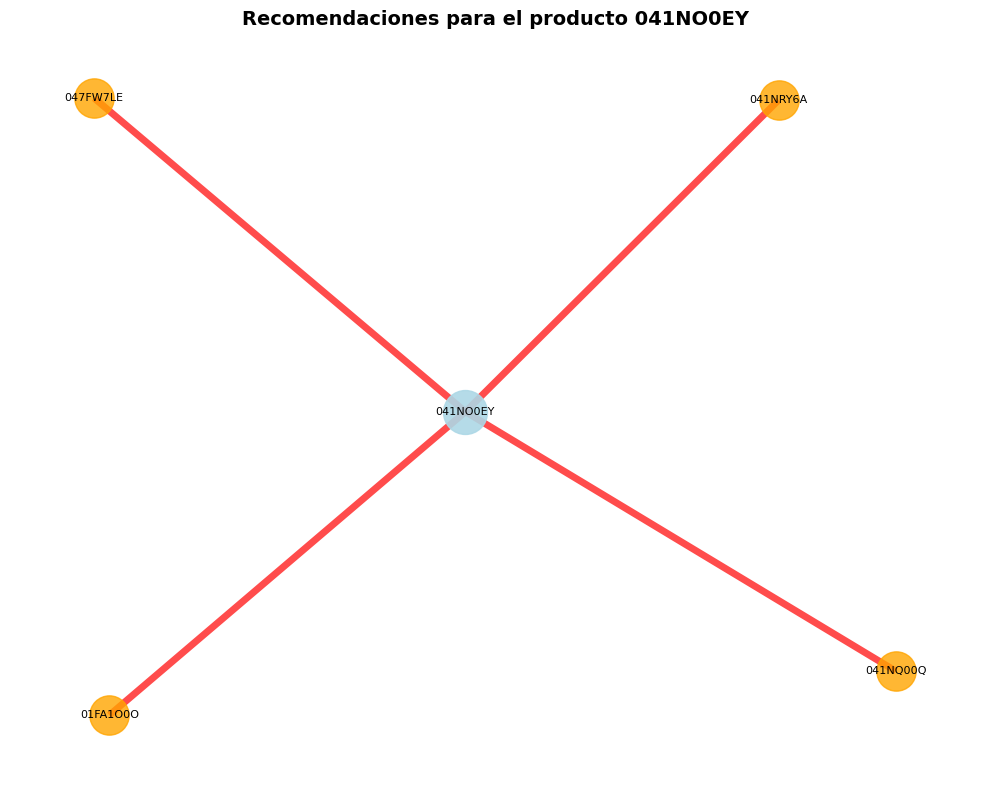

In [15]:
# Mostrar algunos productos disponibles para probar
print("Productos disponibles para probar el sistema de recomendaci√≥n:")
available_products = [p for p in products[:20] if p in product_network and len(product_network[p]) > 0]

for i, prod in enumerate(available_products[:10], 1):
    connections = len(product_network[prod])
    print(f"  {i}. {prod} (tiene {connections} productos similares)")

print(f"\nTotal de productos con conexiones: {len(available_products)}")

# Funci√≥n para probar con un producto espec√≠fico
def test_recommendation_system(product_id, n_recs=4):
    """
    Funci√≥n completa para probar el sistema de recomendaci√≥n
    """
    print("="*60)
    print(f"SISTEMA DE RECOMENDACI√ìN - PRODUCTO: {product_id}")
    print("="*60)
    
    if product_id not in product_network:
        print(f"‚ùå Error: El producto {product_id} no existe en la red")
        return
    
    if len(product_network[product_id]) == 0:
        print(f"‚ùå El producto {product_id} no tiene productos similares")
        return
    
    # Obtener y mostrar recomendaciones
    recommendations = get_product_recommendations(product_id, n_recs)
    
    print(f"üéØ Top {len(recommendations)} productos recomendados:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"   {i}. {prod_id}")
        print(f"      Similaridad: {weight} usuarios en com√∫n")
        print()
    
    # Crear visualizaci√≥n
    visualize_recommendations(product_id, n_recs)

# Ejemplo de uso con el primer producto disponible
if available_products:
    example_product = available_products[0]
    print(f"\nüîç Probando el sistema con el producto: {example_product}")
    test_recommendation_system(example_product, n_recs=4)

### **Paso 4:** An√°lisis de distribuci√≥n de similaridades

Vamos a analizar qu√© tan comunes son las diferentes similaridades en nuestra red de productos.

üìä AN√ÅLISIS DE SIMILARIDADES EN LA RED DE PRODUCTOS
Total de conexiones entre productos: 1,039,629
Similaridad m√≠nima: 1
Similaridad m√°xima: 119
Similaridad promedio: 1.10

üî¢ DISTRIBUCI√ìN DE SIMILARIDADES:
  Similaridad 1: 982,015 conexiones (94.5%)
  Similaridad 2: 41,184 conexiones (4.0%)
  Similaridad 3: 8,750 conexiones (0.8%)
  Similaridad 4: 3,292 conexiones (0.3%)
  Similaridad 5: 1,517 conexiones (0.1%)
  Similaridad 6: 814 conexiones (0.1%)
  Similaridad 7: 557 conexiones (0.1%)
  Similaridad 8: 323 conexiones (0.0%)
  Similaridad 9: 261 conexiones (0.0%)
  Similaridad 10: 185 conexiones (0.0%)
  ... y 49 valores m√°s

‚úÖ S√ç, hay 982,015 conexiones con similaridad = 1
   Esto representa el 94.5% de todas las conexiones
   Significa que 982,015 pares de productos comparten exactamente 1 usuario


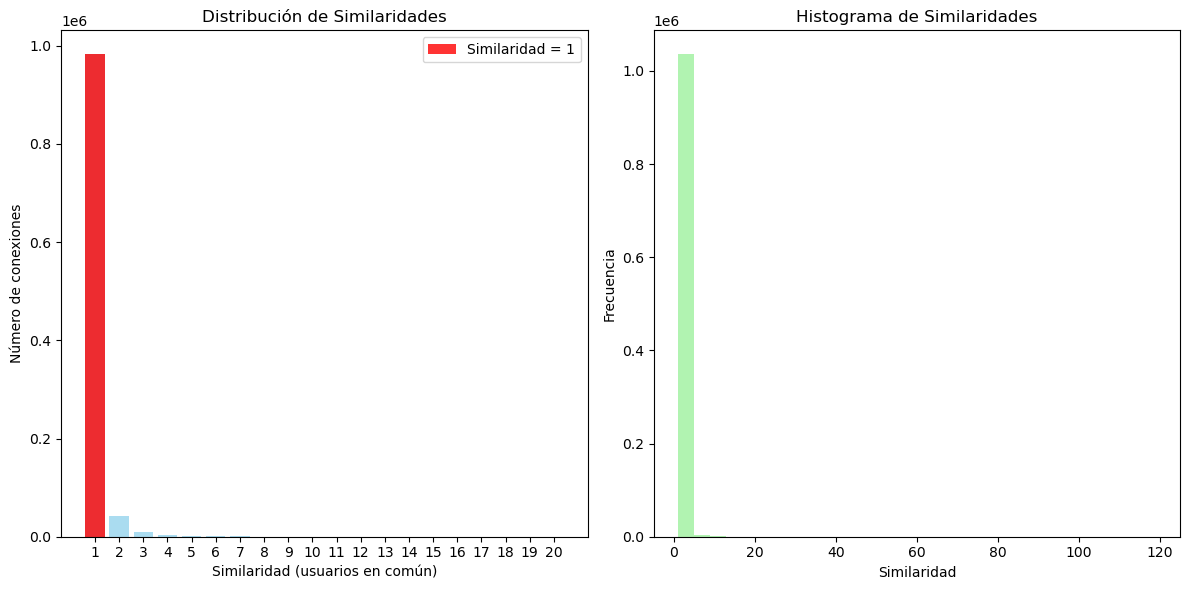

In [ ]:
# SIMPLIFICACI√ìN 10: An√°lisis estad√≠stico m√°s eficiente y conciso
def analyze_similarities():
    """
    FUNCI√ìN SIMPLIFICADA: Analiza distribuci√≥n de similaridades
    
    MEJORAS IMPLEMENTADAS:
    - Funci√≥n reutilizable en lugar de c√≥digo suelto
    - C√°lculos estad√≠sticos m√°s eficientes usando numpy
    - Eliminaci√≥n de imports internos y c√°lculos redundantes
    """
    if product_network.number_of_edges() == 0:
        print("No hay conexiones para analizar")
        return
    
    # SIMPLIFICACI√ìN: Extracci√≥n directa de pesos sin lista intermedia innecesaria
    weights = np.array([data['weight'] for _, _, data in product_network.edges(data=True)])
    
    print("AN√ÅLISIS DE SIMILARIDADES")
    print("=" * 30)
    print(f"Conexiones: {len(weights):,}")
    print(f"Rango: {weights.min()} - {weights.max()}")
    print(f"Promedio: {weights.mean():.2f}")
    
    # SIMPLIFICACI√ìN: Usar numpy para estad√≠sticas m√°s eficientes
    from collections import Counter
    counts = Counter(weights)
    
    # Mostrar distribuci√≥n top 10 de forma m√°s compacta
    print(f"\nTop 10 similaridades:")
    for weight in sorted(counts.keys())[:10]:
        pct = (counts[weight] / len(weights)) * 100
        print(f"  {weight}: {counts[weight]:,} ({pct:.1f}%)")
    
    # Verificaci√≥n de similaridad = 1 simplificada
    sim_1 = counts.get(1, 0)
    if sim_1 > 0:
        print(f"\nSimilaridad = 1: {sim_1:,} casos ({sim_1/len(weights)*100:.1f}%)")
    else:
        print(f"\nNo hay similaridades = 1 (m√≠nima: {weights.min()})")

# Ejecutar an√°lisis
analyze_similarities()
    
    # Gr√°fico de distribuci√≥n
    plt.figure(figsize=(12, 6))
    
    # Limitar a los primeros 20 valores para mejor visualizaci√≥n
    top_weights = sorted(weight_counts.keys())[:20]
    top_counts = [weight_counts[w] for w in top_weights]
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(top_weights)), top_counts, color='skyblue', alpha=0.7)
    plt.xlabel('Similaridad (usuarios en com√∫n)')
    plt.ylabel('N√∫mero de conexiones')
    plt.title('Distribuci√≥n de Similaridades')
    plt.xticks(range(len(top_weights)), top_weights)
    
    # Resaltar similaridad = 1 si existe
    if 1 in top_weights:
        idx_1 = top_weights.index(1)
        plt.bar(idx_1, top_counts[idx_1], color='red', alpha=0.8, label='Similaridad = 1')
        plt.legend()
    
    # Histograma
    plt.subplot(1, 2, 2)
    plt.hist(all_weights, bins=min(30, len(weight_counts)), alpha=0.7, color='lightgreen')
    plt.xlabel('Similaridad')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Similaridades')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay conexiones en la red de productos para analizar")

### **Sistema Completo Simplificado**

Funci√≥n principal que integra todo el sistema de recomendaci√≥n de forma m√°s eficiente y f√°cil de usar.

In [ ]:
def recommendation_system_demo(product_id=None, n_recs=4):
    """
    SISTEMA COMPLETO SIMPLIFICADO
    
    VENTAJAS DE ESTA SIMPLIFICACI√ìN:
    - Una sola funci√≥n para todo el flujo
    - Manejo autom√°tico de errores sin c√≥digo repetitivo
    - Selecci√≥n autom√°tica de producto si no se especifica
    - C√≥digo m√°s mantenible y reutilizable
    
    Args:
        product_id: ID del producto (None para selecci√≥n autom√°tica)
        n_recs: N√∫mero de recomendaciones (default: 4)
    """
    
    # SIMPLIFICACI√ìN 11: Selecci√≥n autom√°tica del mejor producto disponible
    if product_id is None:
        # Encontrar producto con m√°s conexiones
        product_id = max(
            (prod for prod in products if prod in product_network),
            key=lambda p: len(product_network[p]),
            default=None
        )
    
    if not product_id or product_id not in product_network:
        print("No hay productos disponibles para recomendaciones")
        return
    
    # SIMPLIFICACI√ìN 12: Informaci√≥n compacta del producto
    connections = len(product_network[product_id])
    print(f"PRODUCTO: {product_id[-20:]}...")
    print(f"CONEXIONES: {connections}")
    print("-" * 40)
    
    # Generar y mostrar recomendaciones
    recs = get_product_recommendations(product_id, n_recs)
    if recs:
        print("RECOMENDACIONES:")
        for i, (prod, weight) in enumerate(recs, 1):
            bar = "‚ñà" * min(weight, 10)  # Barra visual limitada a 10 caracteres
            print(f"{i}. {prod[-15:]}... | {weight} usuarios | {bar}")
        
        # Visualizaci√≥n simplificada
        visualize_recommendations(product_id, n_recs)
    else:
        print("No se pudieron generar recomendaciones")

# DEMO: Ejecutar sistema completo
print("EJECUTANDO SISTEMA DE RECOMENDACI√ìN SIMPLIFICADO")
print("=" * 50)
recommendation_system_demo()

# DEMO: Con producto espec√≠fico (descomenta para probar)
# recommendation_system_demo("B00006HAXW", 3)

### **Paso 5:** Ejemplo espec√≠fico de similaridad = 1

Vamos a encontrar y analizar un ejemplo real de dos productos con similaridad = 1.

In [ ]:
# Buscar un ejemplo de productos con similaridad = 1
example_found = False

if product_network.number_of_edges() > 0:
    # Iniciar b√∫squeda de ejemplos con similaridad = 1
    print("BUSCANDO EJEMPLO DE SIMILARIDAD = 1...")
    print("="*45)
    
    # Iterar sobre todas las aristas de la red de productos proyectada
    for prod1, prod2, data in product_network.edges(data=True):
        # Verificar si el peso (similaridad) es exactamente 1
        if data['weight'] == 1:
            print(f"ENCONTRADO! Ejemplo de similaridad = 1:")
            print(f"   Producto A: {prod1}")
            print(f"   Producto B: {prod2}")
            print(f"   Similaridad: {data['weight']} usuario en com√∫n")
            
            # Inicializar conjuntos para almacenar usuarios de cada producto
            users_prod1 = set()
            users_prod2 = set()
            
            # Buscar en el grafo bipartito original (B) los usuarios
            # que calificaron el Producto A
            for user in B.neighbors(prod1):
                if user in users:  # Verificar que el nodo sea realmente un usuario
                    users_prod1.add(user)
                    
            # Buscar usuarios que calificaron el Producto B
            for user in B.neighbors(prod2):
                if user in users:  # Verificar que el nodo sea realmente un usuario
                    users_prod2.add(user)
            
            # Encontrar usuarios que calificaron ambos productos (intersecci√≥n)
            users_common = users_prod1.intersection(users_prod2)
            
            # Mostrar detalles del an√°lisis
            print(f"\nDETALLES:")
            print(f"   Usuarios que calificaron Producto A: {len(users_prod1)}")
            print(f"   Usuarios que calificaron Producto B: {len(users_prod2)}")
            print(f"   Usuarios en com√∫n: {len(users_common)}")
            
            # Mostrar IDs de usuarios en com√∫n (m√°ximo 3 para no saturar salida)
            if users_common:
                common_list = list(users_common)
                print(f"   Usuario(s) en com√∫n: {', '.join(common_list[:3])}")
                if len(users_common) > 3:
                    print(f"   ... y {len(users_common) - 3} m√°s")
            
            example_found = True
            break  # Detener b√∫squeda al encontrar el primer ejemplo
    
    # Si no se encontr√≥ ning√∫n ejemplo con similaridad = 1
    if not example_found:
        print("No se encontraron productos con similaridad = 1 en esta muestra")
        print("   Esto puede suceder debido a:")
        print("   - La muestra aleatoria tomada (10% de los datos)")
        print("   - Los filtros aplicados (m√≠nimo 4 conexiones)")
        print("   - La naturaleza de los datos")
        
        # Mostrar cu√°l es la similaridad m√≠nima que s√≠ existe
        all_similarities = [data['weight'] for _, _, data in product_network.edges(data=True)]
        min_similarity = min(all_similarities) if all_similarities else 0
        print(f"\n   La similaridad m√≠nima encontrada es: {min_similarity}")
else:
    print("No hay conexiones en la red de productos para analizar")

## Visualizaci√≥n, An√°lisis e Interactividad